# Before you begin, make sure you close all other COLAB notebooks. 

# Change Runtime settings

## Plesae change your runtime settings to use GPU and high-memory, if you have 

## Runtime --> Change Runtime Type --> GPU wityh high-RAM

In [ ]:
!date # starting time

Tue Feb 16 02:24:11 UTC 2021


## Install AMPL GPU version

```
real	2m59.739s
user	1m48.995s
sys	0m20.614s
```

In [ ]:
%tensorflow_version 1.x

# get the Anaconda file 
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

# install mordred, bravado and molvs
! time conda install -c conda-forge -y mordred bravado molvs

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

--2021-02-19 03:14:38--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94235922 (90M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  89.87M   220MB/s    in 0.4s    

2021-02-19 03:14:39 (220 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [94235922/94235922]

PREFIX=/content/AMPL
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /content/AMPL

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - brotlipy==0.7.0=py38h27cfd23_1003
    - ca-certificates==2020.10.14=0
    - certifi==2020.6.20=pyhd3eb1b0_3
    - cffi==1.14.3=py38h261ae71_2
    - chardet==3.0.4=py38h06a4308_1003
    - conda-package-han

['',
 '/content/AMPL/lib/python3.6/site-packages',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']

## Exploring target activity data from selected database
## Data source = DTC
## Target activity for the receptor CYP3A4

In [ ]:
# There is a problem with the previously imported cffi, so delete it and 
# load it with AMPL instead
if 'cffi' in sys.modules:
  del sys.modules['cffi']

In [ ]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

import json
# import numpy as np
# import pandas as pd
import os
import requests

In [ ]:
#
# Import AMPL libraries
# 
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import pandas as pd
import numpy as np
import getpass,os

/content/AMPL/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Select a target to work with 
### (e.g. PDE2A, KCNH2, SCNA5)

In [ ]:
target_name='CYP3A4'

# Define data locations 

In [ ]:
# ofile=target_name+'_excape_curated.csv'
ofile=target_name+'_dtc_curated.csv'

## Note the file `HTR3A_dtc_smiles.csv` was the output from https://github.com/ravichas/AMPL-Tutorial/blob/master/explore_data_dtc_min_viable_one.ipynb notebook

In [ ]:
import io
url = 'https://raw.githubusercontent.com/jm5159/E4511_FNL_2021Spr/master/cyp3a4_dtc_smiles.csv'
download = requests.get(url).content

In [ ]:
# Reading the downloaded content and turning it into a pandas dataframe
save_smiles_df = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=',', header=0 )

In [ ]:
save_smiles_df

,compound_id,standard_inchi_key,compound_name,synonym,target_id,target_pref_name,gene_names,wildtype_or_mutant,mutation_info,pubmed_id,standard_type,standard_relation,standard_value,standard_units,activity_comment,ep_action_mode,assay_format,assaytype,assay_subtype,inhibitor_type,detection_tech,assay_cell_line,compound_concentration_value,compound_concentration_value_unit,substrate_type,substrate_relation,substrate_value,substrate_units,assay_description,title,journal,doc_type,annotation_comments,PIC50,Unnamed: 0,CID,smiles,rdkit_smiles
0,CHEMBL1232461,AAAQFGUYHFJNHI-SFHVURJKSA-N,GSK525762A,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,24015967.0,IC50,>=,33000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of human CYP3A4,Discovery of epigenetic regulator I-BET762: le...,J. Med. Chem.,PUBLICATION,NaN,4.481486,1,46943432,CCNC(=O)CC1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N1)C4...,CCNC(=O)CC1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-n2c(C...
1,CHEMBL2158292,AADUJBXZMSDOOW-UHFFFAOYSA-N,NaN,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,22039836.0,IC50,>,10000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4,Optimization of a potent class of arylamide co...,J. Med. Chem.,PUBLICATION,NaN,5.000000,5,11533340,C1CCC(=CC1)C2=C(C=CC(=C2)C3CCN(CC3)C(=O)C4=CC=...,N#Cc1cnc(C(=O)Nc2ccc(C3CCN(C(=O)c4cc[n+]([O-])...
2,CHEMBL1086377,AATCBLYHOUOCTO-UHFFFAOYSA-N,KU-0060648,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,23855836.0,IC50,>,10000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4 (unknown origin),"1-substituted (Dibenzo[b,d]thiophen-4-yl)-2-mo...",J. Med. Chem.,PUBLICATION,NaN,5.000000,18,11964036,CCN1CCN(CC1)CC(=O)NC2=C3C4=CC=CC=C4SC3=C(C=C2)...,CCN1CCN(CC(=O)Nc2ccc(-c3cccc4c(=O)cc(N5CCOCC5)...
3,CHEMBL2017279,AAVAYKQPRIQKRX-UHFFFAOYSA-N,NaN,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,22386529.0,IC50,=,1500.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4,From ApoA1 upregulation to BET family bromodom...,Bioorg. Med. Chem. Lett.,PUBLICATION,NaN,5.823909,20,70685377,CC1=C(C(=NO1)C)C2=C(C=C3C(=C2)N=CC(=C3NC4=CC=C...,COc1cc2c(Nc3ccccc3N3CCOCC3)c(C(N)=O)cnc2cc1-c1...
4,CHEMBL490153,ABACVOXFUHDKNZ-UHFFFAOYSA-N,A-867744,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,19419141.0,IC50,>,10000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4,Discovery of 4-(5-(4-chlorophenyl)-2-methyl-3-...,J. Med. Chem.,PUBLICATION,NaN,5.000000,22,23642319,CCC(=O)C1=C(N(C(=C1)C2=CC=C(C=C2)Cl)C3=CC=C(C=...,CCC(=O)c1cc(-c2ccc(Cl)cc2)n(-c2ccc(S(N)(=O)=O)...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6296,CHEMBL180805,ZZGVWUSRXVYCSC-UHFFFAOYSA-N,NaN,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,15745819.0,IC50,=,700.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Selectivity towards cytochrome P450 3A4 enzyme...,Potent and selective [2-imidazol-1-yl-2-(6-alk...,Bioorg. Med. Chem. Lett.,PUBLICATION,NaN,6.154902,16648,11501485,CC(C(C1=CC2=C(C=C1)C=C(C=C2)OCC(C)(C)C)N3C=CN=...,CC(C(c1ccc2cc(OCC(C)(C)C)ccc2c1)n1ccnc1)N(C)C
6297,CHEMBL1076536,ZZHNYWHADLVCEP-UHFFFAOYSA-N,NaN,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,19846298.0,IC50,=,5500.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4 using diethoxyfluorescein...,"Evaluation of basic, heterocyclic ring systems...",Bioorg. Med. Chem. Lett.,PUBLICATION,NaN,5.259637,16650,21717336,CC1=C(C(=CC=C1)C)COC2=CC=CN3C2=NC(=C3C)C,Cc1cccc(C)c1COc1cccn2c(C)c(C)nc12
6298,CHEMBL1076536,ZZHNYWHADLVCEP-UHFFFAOYSA-N,NaN,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,19846298.0,IC50,=,18000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4 using 7-benzyloxyquinolin...,"Evaluation of basic, heterocyclic ring systems...",Bioorg. Med. Chem. Lett.,PUBLICATION,NaN,4.744727,16650,21717336,CC1=C(C(=CC=C1)C)COC2=CC=CN3C2=N

In [ ]:
# save_smiles_df.rename( columns={ "PIC50" : "PXC50" }, inplace=True) 

##Check for assay replicates with high measurement variation and flag them 

In [ ]:
import os

# From our dataframe, we are working with the PIC50 column 
data=save_smiles_df

# Here we are defining our response column, which will be PIC50
column = 'PIC50'

# tolerance: Percentage of individual respsonse values allowed to different from 
# the average to be included in averaging
tolerance = 10

# list_bad_duplicates: Print structures with bad duplicates
list_bad_duplicates = 'Yes'

# max_std: Maximum allowed standard deviation for computed average response value
# NOTE: In this example, we set this value very high to disable this feature
max_std = 1

# compound_id: Compound ID column
compound_id = 'standard_inchi_key'

# smiles_col: SMILES column
smiles_col = 'rdkit_smiles'

# Here we are creating a new dataframe, called check_df
check_df = curate_data.average_and_remove_duplicates(column, tolerance, 
                                                       list_bad_duplicates, 
                                                       data, max_std, 
                                                       compound_id=compound_id, 
                                                       smiles_col=smiles_col)

Bad duplicates removed from dataset
Dataframe size (6183, 42)
List of 'bad' duplicates removed
               standard_inchi_key     PIC50  ...   Perc_Var  VALUE_NUM_std
120   ANBSWCCVJMJABF-AREMUKBSSA-N  8.387216  ...  18.490557       1.850969
121   ANBSWCCVJMJABF-AREMUKBSSA-N  5.769551  ...  18.490557       1.850969
502   CCCCPSHFLXQUBH-UHFFFAOYSA-N  4.275724  ...  19.082857       1.426026
503   CCCCPSHFLXQUBH-UHFFFAOYSA-N  6.292430  ...  19.082857       1.426026
724   CYCGGKILBWERDJ-UHFFFAOYSA-N  4.070581  ...  15.138414       1.026930
...                           ...       ...  ...        ...            ...
6264  ZWVZORIKUNOTCS-OAQYLSRUSA-N  9.301030  ...  41.363480       1.388022
6265  ZWVZORIKUNOTCS-OAQYLSRUSA-N  7.301030  ...  10.966098       1.388022
6266  ZWVZORIKUNOTCS-OAQYLSRUSA-N  5.275724  ...  19.815900       1.388022
6267  ZWVZORIKUNOTCS-OAQYLSRUSA-N  6.301030  ...   4.232593       1.388022
6268  ZWVZORIKUNOTCS-OAQYLSRUSA-N  6.301030  ...   4.232593       1.388022

[118

## Examine the rejected compounds and examine them

In [ ]:
old_compound_id='rdkit_smiles'
new_compound_id='rdkit_smiles'

# Takes all the compounds that aren't part of the curated data frame and prints them
reject=data[~data[old_compound_id].isin(check_df[new_compound_id])]
reject

,compound_id,standard_inchi_key,compound_name,synonym,target_id,target_pref_name,gene_names,wildtype_or_mutant,mutation_info,pubmed_id,standard_type,standard_relation,standard_value,standard_units,activity_comment,ep_action_mode,assay_format,assaytype,assay_subtype,inhibitor_type,detection_tech,assay_cell_line,compound_concentration_value,compound_concentration_value_unit,substrate_type,substrate_relation,substrate_value,substrate_units,assay_description,title,journal,doc_type,annotation_comments,PIC50,Unnamed: 0,CID,smiles,rdkit_smiles
120,CHEMBL482126,ANBSWCCVJMJABF-AREMUKBSSA-N,NaN,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,18572407.0,IC50,=,4.1,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4,Balancing oral exposure with Cyp3A4 inhibition...,Bioorg. Med. Chem. Lett.,PUBLICATION,NaN,8.387216,387,135922386,CC1=CC(=CC2=C1N=C(N2)C3=C(C=CNC3=O)NCC(C4=CC(=...,Cc1cc(N2CCC(N3CCOCC3)CC2)cc2[nH]c(-c3c(NCC(O)c...
121,CHEMBL482126,ANBSWCCVJMJABF-AREMUKBSSA-N,NaN,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,20153189.0,IC50,=,1700.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4 after 20 mins by BFC fluo...,SAR of PXR transactivation in benzimidazole-ba...,Bioorg. Med. Chem. Lett.,PUBLICATION,NaN,5.769551,387,135922386,CC1=CC(=CC2=C1N=C(N2)C3=C(C=CNC3=O)NCC(C4=CC(=...,Cc1cc(N2CCC(N3CCOCC3)CC2)cc2[nH]c(-c3c(NCC(O)c...
502,CHEMBL217716,CCCCPSHFLXQUBH-UHFFFAOYSA-N,ADS-102550,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,17107790.0,IC50,=,53000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP450 3A4,Identification and optimisation of a series of...,Bioorg. Med. Chem. Lett.,PUBLICATION,NaN,4.275724,1447,10452725,C1OC2=C(O1)C=C(C=C2)CNCCN3C=CC(=N3)C4=CC=C(S4)...,O=C(NO)c1ccc(-c2ccn(CCNCc3ccc4c(c3)OCO4)n2)s1
503,CHEMBL217716,CCCCPSHFLXQUBH-UHFFFAOYSA-N,ADS-102550,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,18247554.0,IC50,=,510.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4,Histone deacetylase inhibitors: from bench to ...,J. Med. Chem.,PUBLICATION,NaN,6.292430,1447,10452725,C1OC2=C(O1)C=C(C=C2)CNCCN3C=CC(=N3)C4=CC=C(S4)...,O=C(NO)c1ccc(-c2ccn(CCNCc3ccc4c(c3)OCO4)n2)s1
724,CHEMBL374350,CYCGGKILBWERDJ-UHFFFAOYSA-N,CID 2858522,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,20153655.0,IC50,=,85000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4-mediated hydroxylation of...,Selective benzimidazole inhibitors of the anti...,Bioorg. Med. Chem.,PUBLICATION,NaN,4.070581,2000,2858523,CC1=CC2=C(C=C1C)N(C(=N2)NCCCO)CC(=O)C3=CC(=C(C...,Cc1cc2nc(NCCCO)n(CC(=O)c3cc(C(C)(C)C)c(O)c(C(C...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6264,CHEMBL401930,ZWVZORIKUNOTCS-OAQYLSRUSA-N,BMS-536924,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,18572407.0,IC50,=,0.5,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4,Balancing oral exposure with Cyp3A4 inhibition...,Bioorg. Med. Chem. Lett.,PUBLICATION,NaN,9.301030,16582,135440466,CC1=CC(=CC2=C1N=C(N2)C3=C(C=CNC3=O)NCC(C4=CC(=...,Cc1cc(N2CCOCC2)cc2[nH]c(-c3c(NCC(O)c4cccc(Cl)c...
6265,CHEMBL401930,ZWVZORIKUNOTCS-OAQYLSRUSA-N,BMS-536924,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,18763755.0,IC50,=,50.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of human recombinant CYP3A4 in huma...,Discovery and evaluation of 4-(2-(4-chloro-1H-...,J. Med. Chem.,PUBLICATION,NaN,7.301030,16582,135440466,CC1=CC(=CC2=C1N=C(N2)C3=C(C=CNC3=O)NCC(C4=CC(=...,Cc1cc(N2CCOCC2)cc2[nH]c(-c3c(NCC(O)c4cccc(Cl)c...
6266,CHEMBL401930,ZWVZORIKUNOTCS-OAQYLSRUSA-N,BMS-536924,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,18763755.0,IC50,=,5300.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of human recombinant CYP3A4 in huma...,Discovery and evaluation of 4-(2-(4-chloro-1H-...,J. Med. Chem.,PUBLICATION,N

In [ ]:
# Prints number of unique rejected compound names and rows
print("Number of discarded compounds",reject[compound_id].nunique())

# Apecifies directory for csv file to send rejected data to, saving it as ofile 
ofile = target_name+'.reject_check'

# Sends the rejected compound dataframe to a csv file with the path (ofile) specified above
reject.to_csv(ofile,index=False)

Number of discarded compounds 43


In [ ]:
# Prints all the results of the unique assay tests run on this target
save_smiles_df['assay_description'].unique()

array(['Inhibition of human CYP3A4', 'Inhibition of CYP3A4',
       'Inhibition of CYP3A4 (unknown origin)',
       'Inhibition of human CYP3A4 expressed in Escherichia coli using diethoxyfluorescein substrate by time dependent inhibition assay',
       'Inhibition of human CYP3A4 expressed in Escherichia coli using 7BQ substrate by time dependent inhibition assay',
       'Inhibition of CYP3A4 after 20 mins by BFC fluorescence assay',
       'Inhibition of CYP3A4 assessed as dealkylation of 7-benzyloxy-4-trifluoromethylcoumarin',
       'Inhibition of CYP3A4 using diethoxyfluorescein as substrate',
       'Inhibition of CYP3A4 using 7-benzyloxyquinoline as substrate',
       "Inhibition of human CYP3A4-mediated midazolam 1'-hydroxylase activity",
       'Inhibition of recombinant CYP3A4 expressed in baculovirus-infected insect microsome',
       'Inhibition of recombinant human CYP3A4 in supersomes using midazolam as substrate after 5 mins by LC-MS/MS analysis',
       'Inhibition of 

In [ ]:
# Collects all the non-rejected data into a new frame called data
data=save_smiles_df[~save_smiles_df[compound_id].isin(reject[compound_id])]

# Prints the rows & columns (in that order) of the dataset from above (i.e. all the matching data)
# Shape is an array that can check how large the dataframe is 
# It will print out (x, y), the x is the rows, or lines, and y is the number of columns 
print(data.shape)

(6183, 38)


In [ ]:
data[['standard_inchi_key','rdkit_smiles','standard_relation']].head(5)

,standard_inchi_key,rdkit_smiles,standard_relation
0,AAAQFGUYHFJNHI-SFHVURJKSA-N,CCNC(=O)CC1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-n2c(C...,>=
1,AADUJBXZMSDOOW-UHFFFAOYSA-N,N#Cc1cnc(C(=O)Nc2ccc(C3CCN(C(=O)c4cc[n+]([O-])...,>
2,AATCBLYHOUOCTO-UHFFFAOYSA-N,CCN1CCN(CC(=O)Nc2ccc(-c3cccc4c(=O)cc(N5CCOCC5)...,>
3,AAVAYKQPRIQKRX-UHFFFAOYSA-N,COc1cc2c(Nc3ccccc3N3CCOCC3)c(C(N)=O)cnc2cc1-c1...,=
4,ABACVOXFUHDKNZ-UHFFFAOYSA-N,CCC(=O)c1cc(-c2ccc(Cl)cc2)n(-c2ccc(S(N)(=O)=O)...,>


In [ ]:
#specifies the column we want (response value) and also tells it to include the duplicates
column='PIC50'; #'standard_value'
list_bad_duplicates='Yes'

# Actually compiles all the data with the specifies column and tells what columns to include 
# (inchi_key, smiles, and relation)
temp_df=curate_data.aggregate_assay_data(data, 
                                         value_col=column, 
                                         output_value_col=None,
                                         label_actives=True,
                                         active_thresh=6,
                                         id_col='standard_inchi_key', 
                                         smiles_col='rdkit_smiles', 
                                         relation_col='standard_relation')

#Removes all duplicates from the data frame and puts it in the final, curated dataframe
curated_df = temp_df[~temp_df.isin([np.inf]).any(1)]

0 entries in input table are missing SMILES strings
5033 unique SMILES strings are reduced to 5033 unique base SMILES strings


## Save data to a file

In [ ]:
# prints the number of rows in the before and after curation 
print("before",data.shape[0],"after",curated_df.shape[0])

#prints the first few rows of the "after" (after curation) dataframes
curated_df.head()

before 6183 after 5033


,compound_id,base_rdkit_smiles,relation,PIC50,active
0,QEHHTVFVEDPISA-UHFFFAOYSA-N,Cc1cccc(C)c1CNc1nc(-c2cccc(=O)[nH]2)cc2c(C)c(C...,,5.771817,0
1,MXDWNZUMSIYAFL-UHFFFAOYSA-N,O=[N+]([O-])c1cc(O)c2c(c1)S(=O)(=O)N=C(Nc1cccc...,>,4.602060,0
2,QYMLHNYPNZUQCL-UHFFFAOYSA-N,O=C(NC1CC1c1ccccc1)N1CCC(c2nnco2)CC1,>,5.000000,0
3,SCCIUWBTSOHVEK-VYQNARHWSA-N,C=CCN1CC(=O)N2C(Cc3ccc(O)cc3)C(=O)N(Cc3cccc4c(...,>,4.602060,0
4,PXISBMZXCKNRIL-UHFFFAOYSA-N,O=C(C(c1ccc(Cl)cc1)c1cncnc1)N1CCN(c2ccc(C(F)(F...,,4.744727,0


In [ ]:
# Prints number of unique resjected compound names/rows
print("Number of discarded compounds",reject[compound_id].nunique())

# Apecifies directory for csv file to send rejected data to, saving it as ofile 
ofile=target_name+'.reject_check.csv'

# Sends the rejected compound dataframe to a csv file with the path (ofile) specified above
reject.to_csv(ofile,index=False)

Number of discarded compounds 43


In [ ]:
# specifies file path to save the curated data to
ofile = target_name+'_dtc_smiles_curated.csv'

# sends data from the curated_df to csv with specified path above
curated_df.to_csv(ofile,index=False)

(0.0, 12.0)

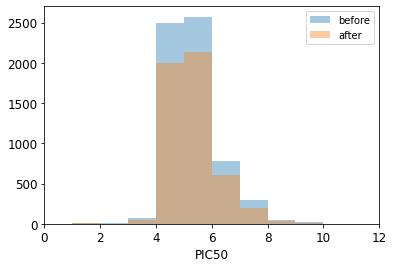

In [ ]:
# load graphics libraries matplotlib and seaborn (sns)
import matplotlib.pyplot as plt
import seaborn as sns

# plt.subplots is a function that creates a full grid of subplots in a single array, and returning 
# them in a NumPy array
# A NumPy array is a grid of values, all of the same type, and is indexed by a tubule of nonnegative integers 
# We are saving this subplots we're creating as fig, ax variables
fig, ax = plt.subplots()

# compiles the data frames before and after all the curation with the specified column value (response values)
# If we remember or look up further in the notebook, we created two dataframes: data and curated_df 
# Our data dataframe consists of ofile (target_name+'_excape_curated.csv.'+username) and we will be using the PIC50 column of our dataframe
# This will be our before variable
before=save_smiles_df["PIC50"]

# Our after variable is comprised of our curated_df dataframe 
# Our curated_df was configured earlier to discard any out of range values
after=curated_df["PIC50"]

# plots the values of the response value column of both the before and after dataframes from above
# sns.distplot is a Seaborn distplot, which allows you to show a histogram with a line on it
# A distplot plots a univariate distribution of observations 
# Below, we are separating our data set into a before section and an after section 
# To break down the sns.distplot functions: 
# bins=range(0, 12, 1) is used to bin our range of values, meaning to divide the entire range of values into a series of intervals
# ax=ax 
# kde is a kernel density estimate plot that represents the data using a continuous probability density curve
# kde=False will remove the density line on the histogram
# The label= function is used to label different sections of our plot 
sns.distplot(before, bins=range(0, 12, 1), ax=ax, kde=False, label='before')
sns.distplot(after, bins=range(0, 12, 1), ax=ax, kde=False, label='after')

#configures plot by adding a legend and setting the x axis limits for readability
# plt.legend() adds the legend to the plot
plt.legend()

# ax.set_xlim is setting the x-axis limits of the graph, setting it to be from (0,12)
ax.set_xlim([0, 12])


In [ ]:
!date # ending time

Fri Feb 12 20:53:04 UTC 2021
